In [1]:
#libraris
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random 
%matplotlib inline

In [2]:
#loading data

words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:2])

32033
15
['emma', 'olivia']


In [3]:
# build the vocab of char mapping from/to int
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab = len(stoi)
print(itos)
print(vocab)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [17]:
random.seed()
random.shuffle(words)


In [18]:
blocksiz = 8 #8 chars
def buildDataset(words):
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            contxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xTrain, yTrain = buildDataset(words[:n1])
xDev, yDev = buildDataset(words[n1:n2])
xTst, yTst = buildDataset(words[n2:])



torch.Size([182499, 8]) torch.Size([182499])
torch.Size([22909, 8]) torch.Size([22909])
torch.Size([22738, 8]) torch.Size([22738])


In [6]:
for x, y in  zip(xTrain[:10], yTrain[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> a
.......a --> l
......al --> e
.....ale --> i
....alei --> r
...aleir --> a
..aleira --> .
........ --> d
.......d --> e
......de --> a


In [20]:

class Linear:
    def __init__(self, fanIn, fanOut, bias=True):
        self.weights = torch.randn((fanIn, fanOut)) / fanIn**0.5 #kaiming init
        self.bias = torch.zeros(fanOut) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def para(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #para Trined with backProp
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffer trained with running momentum updat
        self.runningMean = torch.zeros(dim)
        self.runningVariance = torch.ones(dim)
    
    
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)

            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.runningMean
            xvar = self.runningVariance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        #update buffers
        if self.training:
            with torch.no_grad():
                self.runningMean = (1 - self.momentum) * self.runningMean + self.momentum * xmean
                self.runningVariance = (1 - self.momentum) * self.runningVariance + self.momentum * xvar
        return self.out
    
    def para(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def para(self):
        return []


#this will replace [ C ] embeding
class Embedding:
    def __init__(self, numEmd, embDim):
        self.weight = torch.randn((numEmd, embDim)) 
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def para(self):
        return [self.weight]

#this will replace this ||   x = emb.view(emb.shape[0], -1)
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        #self.out = x.view(x.shape[0], -1)
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)  
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def para(self):
        return []
    
#This is == to Tensorflow [[ tf.keras.models.Seqential[...] ]]
class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for lyr in self.layers:
            x = lyr(x)
        self.out = x
        return self.out
    def para(self):
        #get all the para of all layers and strech them into one list
        return [p for lyr in self.layers for p in lyr.para()]

In [21]:
torch.manual_seed(42)

In [22]:
nemb = 24 #10 dim of char embeding vector
nhidden = 128 #the num of neuron in hidden layer of MLP 

#C = torch.randn((vocab, nemb))
model = Sequential([
    Embedding(vocab, nemb),
    FlattenConsecutive(2), Linear(nemb * 2, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(), #nemb*2==20 which is what we want
    FlattenConsecutive(2), Linear(nhidden * 2, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(), 
    FlattenConsecutive(2), Linear(nhidden * 2, nhidden ,bias=False), BatchNorm1d(nhidden), Tanh(), 
    Linear(nhidden, vocab)
])

with torch.no_grad():
    model.layers[-1].weights *= 0.1 #last layer make less confident

#para = [p for layer in layers for p in layer.para()]
para = model.para()
print(sum(p.nelement() for p in para))
for p in para:
    p.requires_grad = True
    

76579


In [14]:
for lyr in model.layers:
    print(lyr.__class__.__name__, ':', tuple(lyr.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [24]:
maxSteps = 200000
batchSiz = 32
loss_i = []

for i in range(maxSteps):
    ix = torch.randint(0, xTrain.shape[0], (batchSiz,))
    xb, yb = xTrain[ix], yTrain[ix]

    #forward pass
    
    #// bothe of those codes are inside the layer, Cos of [[Embedding,Flatten]] Modules
    #emb = C[xb] #embeded char into vector
    #x = emb.view(emb.shape[0], -1)
    
    logits = model(xb)#call model in input data
    loss = F.cross_entropy(logits, yb)

    #backward pass
    for p in para:
        p.grad = None
    loss.backward()

    #updt the simple SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    #track status 
    if i % 10000 == 0:
        print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 
    
   

      0/ 200000: 2.5201
  10000/ 200000: 1.9606
  20000/ 200000: 2.1746
  30000/ 200000: 1.7335
  40000/ 200000: 1.8969
  50000/ 200000: 1.9840
  60000/ 200000: 2.1041
  70000/ 200000: 1.9338
  80000/ 200000: 1.6839
  90000/ 200000: 2.3200
 100000/ 200000: 2.1774
 110000/ 200000: 2.1667
 120000/ 200000: 1.7935
 130000/ 200000: 1.8650
 140000/ 200000: 1.4819
 150000/ 200000: 1.5606
 160000/ 200000: 1.6375
 170000/ 200000: 2.1617
 180000/ 200000: 1.5704
 190000/ 200000: 1.6044


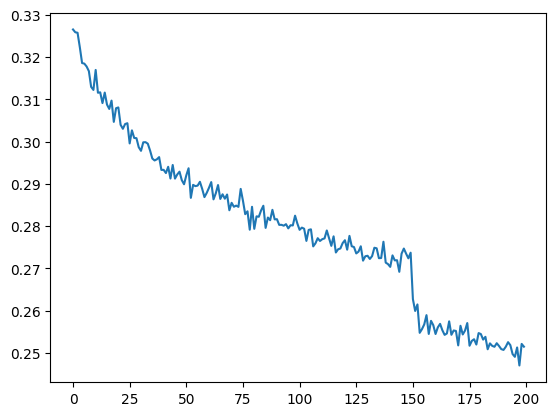

In [25]:

plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [26]:
#put layer into eval mode (needed for batchnorm especialy)
for lyr in model.layers:
    lyr.training = False

In [27]:
#evaluate the loss
@torch.no_grad()
def spltLoss(split):
    x, y = {
        'train':(xTrain, yTrain),
        'dev':(xDev, yDev),
        'test':(xTst, yTst)
    }[split]
    
    #emb = C[x]
    #x = emb.view(emb.shape[0], -1)
    #for lyr in layers:
    #    x = lyr(x)
    
    logits = model(x)    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

spltLoss('train')
spltLoss('dev')



train 1.7653266191482544
dev 1.993830919265747


# Before Optimize the model,


In [63]:
#sampling from the Model

for i in range(20):
    out = []
    contxt = [0] * blocksiz
    while True:
        #emb = C[torch.tensor([contxt])]
        #x = emb.view(emb.shape[0], -1)
        #for lyr in layers:
        #    x = lyr(x)

        logits = model(torch.tensor([contxt]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the contxt window and track the sample
        contxt = contxt[1:] + [ix]
        out.append(ix)
        #if sample specil token[.] break
        if ix==0:
            break
    print(''.join(itos[i] for i in out))



kalissa.
raythale.
jebriel.
joannah.
bella.
natalina.
dalilo.
tarriel.
arnard.
demoni.
aaiden.
kynn.
pelana.
miyar.
breo.
delliana.
patter.
clayton.
cambrielle.
daley.


# Why Convolutions... Brief

In [49]:
for x, y in zip(xTrain[12:18], yTrain[12:18]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()]) 

........ ---> s
.......s ---> o
......so ---> l
.....sol ---> a
....sola ---> n
...solan ---> .


In [55]:
# forward a simple exmple
logits = model(xTrain[[12]])
logits.shape


torch.Size([1, 27])

In [56]:
#forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(xTrain[[7+i]])

logits.shape

torch.Size([8, 27])